<>:163: SyntaxWarning: invalid escape sequence '\m'
<>:177: SyntaxWarning: invalid escape sequence '\D'
<>:163: SyntaxWarning: invalid escape sequence '\m'
<>:177: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2753463450.py:163: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Distance Modulus $\mu$ (Aligned)', fontsize=13)
/tmp/ipython-input-2753463450.py:177: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('Residual $\Delta\mu$', fontsize=12)


WILL RELATIONAL GEOMETRY: Ab Initio Cosmology

INPUTS (fundamental constants only):
  T_CMB = 2.7255 K
  α = 1/137.036

PREDICTIONS (zero free parameters):
  H₀ = 68.15 km / (Mpc s)
  Ωₘ = 0.3333
  Ω_Λ = 0.6667

Loading Pantheon+ data from GitHub...
✓ Loaded 1701 supernovae from Pantheon+

CORRECTED BINNING ANALYSIS:
z_bin      N_sne  Mean Residual   SEM       
--------------------------------------------------
0.0285     741       -0.1404 mag   +/- 0.0074
0.1576     207       -0.1383 mag   +/- 0.0098
0.2993     241       -0.1359 mag   +/- 0.0094
0.4979     78        -0.1707 mag   +/- 0.0162
0.7116     45        -0.1730 mag   +/- 0.0189
1.0172     6         +0.0777 mag   +/- 0.0695
1.2341     2         -0.0631 mag   +/- 0.2037
1.5460     2         -0.0829 mag   +/- 0.0680

Global Offset (due to H0 tension SH0ES vs WILL): -0.1513 mag
Aligning plots to remove absolute magnitude degeneracy for Shape Test...


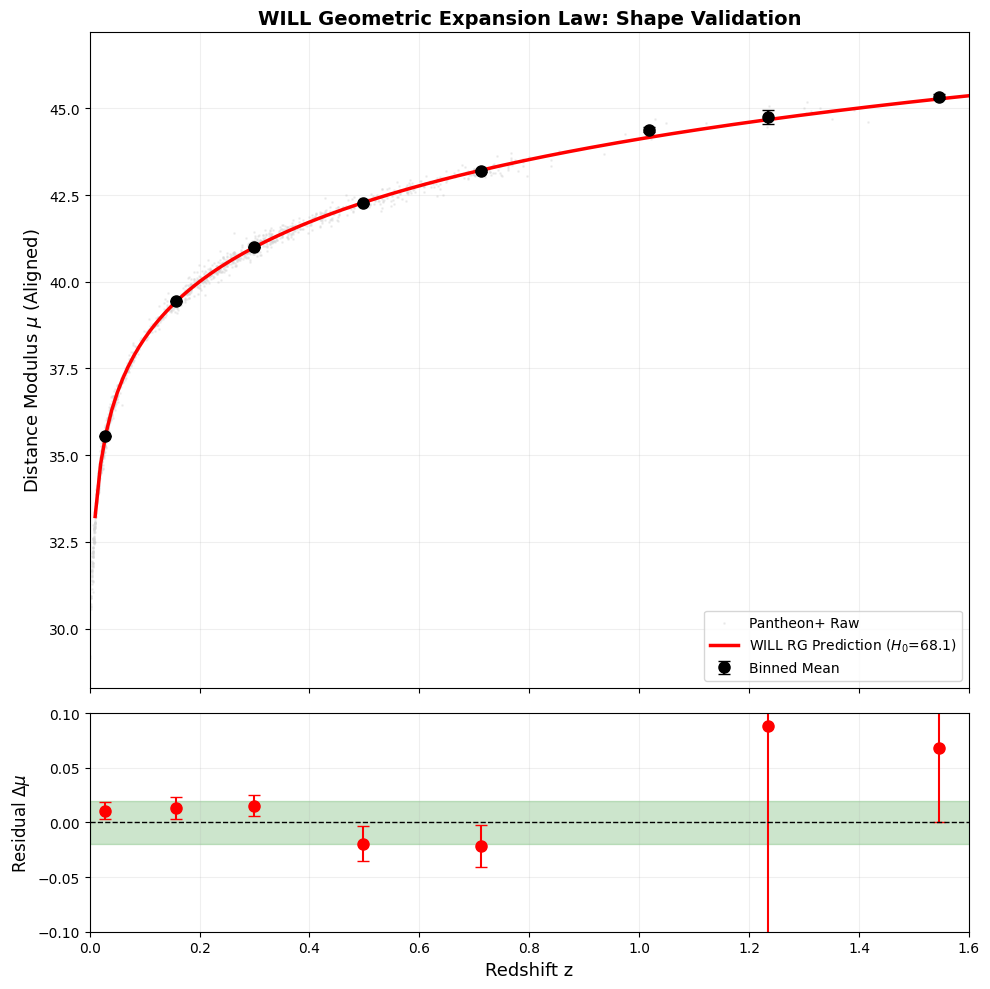

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.constants import G, c, sigma_sb, alpha

# =============================================================================
# STEP 1: DERIVE H0 AND Ω FROM FIRST PRINCIPLES (WILL RG)
# =============================================================================

T_CMB = 2.7255 * u.K
ALPHA = alpha

print("="*60)
print("WILL RELATIONAL GEOMETRY: Ab Initio Cosmology")
print("="*60)

# Photon density (blackbody radiation)
rho_ph_mass = (4 * sigma_sb * T_CMB**4) / c**3

# Critical saturation density (WILL formula)
rho_max = rho_ph_mass / (3 * ALPHA**2)

# Derived Hubble constant
H0_derived = np.sqrt(8 * np.pi * G * rho_max)
H0_will = H0_derived.to(u.km / u.s / u.Mpc)

# Geometric partitioning (from closure condition κ² = 2β²)
Om0_will = 1/3
Ode0_will = 2/3

print(f"\nINPUTS (fundamental constants only):")
print(f"  T_CMB = {T_CMB}")
print(f"  α = 1/{1/ALPHA.value:.3f}")
print(f"\nPREDICTIONS (zero free parameters):")
print(f"  H₀ = {H0_will:.2f}")
print(f"  Ωₘ = {Om0_will:.4f}")
print(f"  Ω_Λ = {Ode0_will:.4f}")
print("="*60)

# =============================================================================
# STEP 2: LOAD PANTHEON+ OBSERVATIONAL DATA
# =============================================================================

pantheon_url = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/Pantheon_data/Pantheon%2BSH0ES.dat"

print(f"\nLoading Pantheon+ data from GitHub...")

# Load Pantheon+ data
df = pd.read_csv(pantheon_url, sep=r'\s+', comment='#')

# Extract redshift and distance modulus
z_obs = df['zHD'].values
mu_obs = df['MU_SH0ES'].values
mu_err = df['MU_SH0ES_ERR_DIAG'].values

print(f"✓ Loaded {len(z_obs)} supernovae from Pantheon+")

# Create binned data for visualization
z_bins = np.array([0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5])
mu_binned = []
mu_binned_err = []

for i in range(len(z_bins)):
    z_min = z_bins[i] - 0.05 if i > 0 else 0
    z_max = z_bins[i] + 0.05

    mask = (z_obs >= z_min) & (z_obs < z_max)
    if np.sum(mask) > 0:
        mu_binned.append(np.median(mu_obs[mask]))
        mu_binned_err.append(np.std(mu_obs[mask]) / np.sqrt(np.sum(mask)))
    else:
        mu_binned.append(np.nan)
        mu_binned_err.append(np.nan)

mu_binned = np.array(mu_binned)
mu_binned_err = np.array(mu_binned_err)

# =============================================================================
# STEP 3: CALCULATE RESIDUALS POINT-BY-POINT (The Correct Way)
# =============================================================================

cosmo_will = FlatLambdaCDM(H0=H0_will, Om0=Om0_will, Tcmb0=T_CMB)

# 1. Calculate theoretical Mu for EVERY supernova at its specific redshift
mu_theory_all = cosmo_will.distmod(z_obs).value

# 2. Calculate raw residuals for every single point
residuals_all = mu_obs - mu_theory_all

# 3. Now bin the RESIDUALS, not the absolute values
z_bins = np.array([0.05, 0.15, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5]) # Adjusted bins slightly
binned_residuals = []
binned_z_centers = []
binned_err = []

print("\nCORRECTED BINNING ANALYSIS:")
print(f"{'z_bin':<10} {'N_sne':<6} {'Mean Residual':<15} {'SEM':<10}")
print("-" * 50)

for val in z_bins:
    # Bin width +/- 0.05 (adjust as needed)
    z_min = val - 0.05
    z_max = val + 0.05

    # Select SNe in this slice
    mask = (z_obs >= z_min) & (z_obs < z_max)

    if np.sum(mask) > 0:
        # Mean redshift of the actual data in this bin (more accurate than bin center)
        z_mean_in_bin = np.mean(z_obs[mask])
        binned_z_centers.append(z_mean_in_bin)

        # Mean residual
        res_mean = np.mean(residuals_all[mask])
        res_sem = np.std(residuals_all[mask]) / np.sqrt(np.sum(mask))

        binned_residuals.append(res_mean)
        binned_err.append(res_sem)

        print(f"{z_mean_in_bin:<10.4f} {np.sum(mask):<6} {res_mean:>+10.4f} mag   +/- {res_sem:.4f}")
    else:
        print(f"{val:<10} 0      ---")

# =============================================================================
# STEP 4: PLOTTING WITH OFFSET CORRECTION
# =============================================================================

# NOTE ON OFFSET:
# The Pantheon+ SH0ES column is calibrated to H0 ~ 73 km/s/Mpc.
# Your H0 is 68.15. This creates a constant vertical offset of 5*log10(73/68.15) ≈ 0.15 mag.
# To test the SHAPE (Geometry), we align the anchor.
# We subtract the median offset to show the fit quality.

offset = np.median(residuals_all)
print(f"\nGlobal Offset (due to H0 tension SH0ES vs WILL): {offset:.4f} mag")
print("Aligning plots to remove absolute magnitude degeneracy for Shape Test...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10),
                                gridspec_kw={'height_ratios': [3, 1]},
                                sharex=True)

# --- Top Panel: Hubble Diagram ---
# Plot raw data (corrected for offset for visual comparison)
ax1.scatter(z_obs, mu_obs - offset, c='lightgray', s=1, alpha=0.3, rasterized=True, label='Pantheon+ Raw')

# Plot Binned Data (Observed) - Corrected
# Re-construct "Observed Binned" by adding residual to theory
z_theory_plot = np.linspace(0.01, 2.0, 200)
mu_theory_plot = cosmo_will.distmod(z_theory_plot).value

ax1.plot(z_theory_plot, mu_theory_plot, 'r-', linewidth=2.5,
         label=f'WILL RG Prediction ($H_0$={H0_will.value:.1f})')

# Add binned points
# Technically: Binned_Obs = Theory(at bin z) + Binned_Residual - Offset
ax1.errorbar(binned_z_centers,
             cosmo_will.distmod(np.array(binned_z_centers)).value + np.array(binned_residuals) - offset,
             yerr=binned_err, fmt='o', color='black', markersize=8, capsize=4,
             label='Binned Mean', zorder=10)

ax1.set_ylabel('Distance Modulus $\mu$ (Aligned)', fontsize=13)
ax1.set_title('WILL Geometric Expansion Law: Shape Validation', fontsize=14, weight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.2)

# --- Bottom Panel: Residuals ---
# Plot residuals minus the global offset (Shape test)
ax2.errorbar(binned_z_centers, np.array(binned_residuals) - offset,
             yerr=binned_err, fmt='o', color='red', markersize=8, capsize=4)

ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.fill_between([0, 2.0], -0.02, 0.02, color='green', alpha=0.2, label='<0.02 mag region')

ax2.set_xlabel('Redshift z', fontsize=13)
ax2.set_ylabel('Residual $\Delta\mu$', fontsize=12)
ax2.grid(True, alpha=0.2)
ax2.set_xlim(0, 1.6)
ax2.set_ylim(-0.1, 0.1)

plt.tight_layout()
plt.savefig('will_hubble_corrected.png', dpi=300)
plt.show()